In [21]:
# 1. Import Necessary Packages
import networkx as nx
import numpy as np
import random
import community.community_louvain as community_louvain
from scipy.stats import ttest_ind, f_oneway
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

In [3]:
# 2. Load Data and Construct Graph
def load_edges(filename: str) -> List[Tuple[int, int]]:
    edges = []
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:
                source, target = map(int, parts)
                edges.append((source, target))
    return edges

def construct_graph(edges: List[Tuple[int, int]], ego_node: int) -> nx.Graph:
    G = nx.Graph()
    G.add_node(ego_node)
    G.add_edges_from(edges)
    return G

node_id = 0  # TODO: Create script to do this for all ids
edges_file = f"data/{node_id}.edges"
edges = load_edges(edges_file)
G = construct_graph(edges, ego_node=node_id)

In [4]:
# 3. Calculate Node Properties
degrees = dict(G.degree())
clustering_coeffs = nx.clustering(G)
betweenness = nx.betweenness_centrality(G)
closeness = nx.closeness_centrality(G)

In [5]:
# 4. Perform Community Detection Using Louvain Algorithm
partition = community_louvain.best_partition(G)

In [6]:
# 5. Calculate Average Clustering Coefficient Within Communities
def calculate_community_clustering(graph: nx.Graph, partition: Dict[int, int]) -> Dict[int, float]:
    community_clustering = {}
    communities = {}
    for node, community_id in partition.items():
        communities.setdefault(community_id, []).append(node)
    for community_id, nodes in communities.items():
        subgraph = graph.subgraph(nodes)
        clustering_coeffs = nx.clustering(subgraph)
        avg_clustering = sum(clustering_coeffs.values()) / len(clustering_coeffs)
        community_clustering[community_id] = avg_clustering
    return community_clustering

community_clustering = calculate_community_clustering(G, partition)

In [7]:
# 6. Identify Highly Clustered Communities
network_avg_clustering = nx.average_clustering(G)

def get_highly_clustered_communities(community_clustering: Dict[int, float], network_avg_clustering: float) -> List[int]:
    highly_clustered_communities = [community_id for community_id, avg_clustering in community_clustering.items()
                                    if avg_clustering > network_avg_clustering]
    return highly_clustered_communities

highly_clustered_communities = get_highly_clustered_communities(community_clustering, network_avg_clustering)
print(f"Network Average Clustering Coefficient: {network_avg_clustering:.4f}")
print(f"Highly Clustered Communities: {highly_clustered_communities}")

Network Average Clustering Coefficient: 0.5067
Highly Clustered Communities: [1, 2, 3, 10, 7, 8, 9, 13]


In [8]:
# 7. Identify High-Degree Nodes (Top 10%)
def get_high_degree_nodes(degrees: Dict[int, int], percentile: float = 90) -> List[int]:
    degree_values = list(degrees.values())
    threshold = np.percentile(degree_values, percentile)
    high_degree_nodes = [node for node, degree in degrees.items() if degree >= threshold]
    return high_degree_nodes

high_degree_nodes = get_high_degree_nodes(degrees, percentile=90)
print(f"High-Degree Nodes (Top 10%): {high_degree_nodes}")

High-Degree Nodes (Top 10%): [186, 122, 285, 271, 304, 9, 213, 252, 332, 26, 280, 272, 199, 239, 172, 322, 170, 56, 188, 315, 119, 323, 200, 98, 67, 325, 277, 21, 169, 142, 203, 261, 25, 40, 113]


In [9]:
# 8. Identify Bridge Nodes
def get_bridge_nodes(high_degree_nodes: List[int], partition: Dict[int, int], highly_clustered_communities: List[int]) -> List[int]:
    bridge_nodes = [node for node in high_degree_nodes if partition.get(node) in highly_clustered_communities]
    return bridge_nodes

bridge_nodes = get_bridge_nodes(high_degree_nodes, partition, highly_clustered_communities)
print(f"Bridge Nodes: {bridge_nodes}")

Bridge Nodes: [186, 122, 285, 271, 304, 9, 252, 332, 26, 280, 272, 199, 239, 172, 322, 170, 56, 188, 315, 323, 200, 98, 67, 325, 277, 21, 169, 142, 203, 261, 25, 40, 113]


In [11]:
# 9. Identify High-Degree Nodes Not in Highly Clustered Communities
def get_high_degree_nodes_not_in_highly_clustered_communities(high_degree_nodes: List[int], partition: Dict[int, int], highly_clustered_communities: List[int]) -> List[int]:
    nodes = [node for node in high_degree_nodes if partition.get(node) not in highly_clustered_communities]
    return nodes

high_degree_nodes_not_in_hcc = get_high_degree_nodes_not_in_highly_clustered_communities(high_degree_nodes, partition, highly_clustered_communities)
print(f"High-Degree Nodes Not in Highly Clustered Communities: {high_degree_nodes_not_in_hcc}")

High-Degree Nodes Not in Highly Clustered Communities: [213, 119]


In [12]:
# 10. Select Random Nodes
def get_random_nodes(graph: nx.Graph, num_nodes: int) -> List[int]:
    return random.sample(list(graph.nodes()), num_nodes)

num_bridge_nodes = len(bridge_nodes)
random_nodes = get_random_nodes(G, num_bridge_nodes)
print(f"Random Nodes: {random_nodes}")

Random Nodes: [186, 203, 9, 149, 244, 258, 177, 80, 231, 40, 324, 230, 262, 146, 269, 10, 317, 246, 94, 118, 66, 34, 314, 245, 252, 256, 278, 291, 295, 212, 266, 325, 158]


In [13]:
# 11. Define the Independent Cascade Model Function
def independent_cascade(graph: nx.Graph, seeds: List[int], propagation_prob: float = 0.1, max_steps: int = None) -> List[int]:
    activated_nodes = set(seeds)
    newly_activated_nodes = set(seeds)
    steps = 0
    while newly_activated_nodes and (max_steps is None or steps < max_steps):
        steps += 1
        next_newly_activated = set()
        for node in newly_activated_nodes:
            neighbors = set(graph.neighbors(node)) - activated_nodes
            for neighbor in neighbors:
                if random.random() <= propagation_prob:
                    next_newly_activated.add(neighbor)
                    activated_nodes.add(neighbor)
        newly_activated_nodes = next_newly_activated
    return list(activated_nodes)

In [14]:
# 12. Define Simulation Function
def simulate_spread(graph: nx.Graph, seed_nodes: List[int], num_simulations: int = 100, propagation_prob: float = 0.1) -> Dict[int, List[int]]:
    results = {}
    for seed in seed_nodes:
        spread_sizes = []
        for _ in range(num_simulations):
            activated_nodes = independent_cascade(graph, seeds=[seed], propagation_prob=propagation_prob)
            spread_sizes.append(len(activated_nodes))
        results[seed] = spread_sizes
    return results

In [15]:
# 13. Simulate Spread for Each Group
num_simulations = 100
propagation_prob = 0.1

# Simulate spread for bridge nodes
bridge_results = simulate_spread(G, bridge_nodes, num_simulations=num_simulations, propagation_prob=propagation_prob)

# Simulate spread for high-degree nodes not in HCC
high_degree_results = simulate_spread(G, high_degree_nodes_not_in_hcc, num_simulations=num_simulations, propagation_prob=propagation_prob)

# Simulate spread for random nodes
random_results = simulate_spread(G, random_nodes, num_simulations=num_simulations, propagation_prob=propagation_prob)

In [17]:
# 14. Collect Spread Sizes
def collect_spread_sizes(results: Dict[int, List[int]]) -> List[int]:
    spread_sizes = []
    for sizes in results.values():
        spread_sizes.extend(sizes)
    return spread_sizes

bridge_spread_sizes = collect_spread_sizes(bridge_results)
high_degree_spread_sizes = collect_spread_sizes(high_degree_results)
random_spread_sizes = collect_spread_sizes(random_results)

In [18]:
# 15. Perform Statistical Analysis
# Perform one-way ANOVA
F_statistic, p_value = f_oneway(bridge_spread_sizes, high_degree_spread_sizes, random_spread_sizes)
print("ANOVA results:")
print(f"F-statistic: {F_statistic:.4f}, p-value: {p_value:.4f}")

# T-tests
t_statistic1, p_value1 = ttest_ind(bridge_spread_sizes, high_degree_spread_sizes, equal_var=False)
print("\nT-test between bridge nodes and high-degree nodes not in HCC:")
print(f"t-statistic: {t_statistic1:.4f}, p-value: {p_value1:.4f}")

t_statistic2, p_value2 = ttest_ind(bridge_spread_sizes, random_spread_sizes, equal_var=False)
print("\nT-test between bridge nodes and random nodes:")
print(f"t-statistic: {t_statistic2:.4f}, p-value: {p_value2:.4f}")

t_statistic3, p_value3 = ttest_ind(high_degree_spread_sizes, random_spread_sizes, equal_var=False)
print("\nT-test between high-degree nodes not in HCC and random nodes:")
print(f"t-statistic: {t_statistic3:.4f}, p-value: {p_value3:.4f}")

ANOVA results:
F-statistic: 1137.3590, p-value: 0.0000

T-test between bridge nodes and high-degree nodes not in HCC:
t-statistic: -0.4403, p-value: 0.6601

T-test between bridge nodes and random nodes:
t-statistic: 46.3708, p-value: 0.0000

T-test between high-degree nodes not in HCC and random nodes:
t-statistic: 33.8594, p-value: 0.0000


In [19]:
# 16. Print Spread Statistics for Each Group
def print_spread_statistics(spread_sizes: List[int], group_name: str):
    print(f"\n--- Spread Statistics for {group_name} ---")
    print(f"Average Spread Size: {np.mean(spread_sizes):.2f}")
    print(f"Median Spread Size: {np.median(spread_sizes):.2f}")
    print(f"Standard Deviation: {np.std(spread_sizes):.2f}")
    print(f"Minimum Spread Size: {np.min(spread_sizes)}")
    print(f"Maximum Spread Size: {np.max(spread_sizes)}")

print_spread_statistics(bridge_spread_sizes, "Bridge Nodes")
print_spread_statistics(high_degree_spread_sizes, "High-Degree Nodes Not in HCC")
print_spread_statistics(random_spread_sizes, "Random Nodes")


--- Spread Statistics for Bridge Nodes ---
Average Spread Size: 138.35
Median Spread Size: 140.00
Standard Deviation: 17.32
Minimum Spread Size: 1
Maximum Spread Size: 180

--- Spread Statistics for High-Degree Nodes Not in HCC ---
Average Spread Size: 138.91
Median Spread Size: 141.00
Standard Deviation: 17.24
Minimum Spread Size: 2
Maximum Spread Size: 185

--- Spread Statistics for Random Nodes ---
Average Spread Size: 80.83
Median Spread Size: 129.00
Standard Deviation: 69.12
Minimum Spread Size: 1
Maximum Spread Size: 179


C:\Users\KAMALA\AppData\Local\Temp\ipykernel_15916\3430045800.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


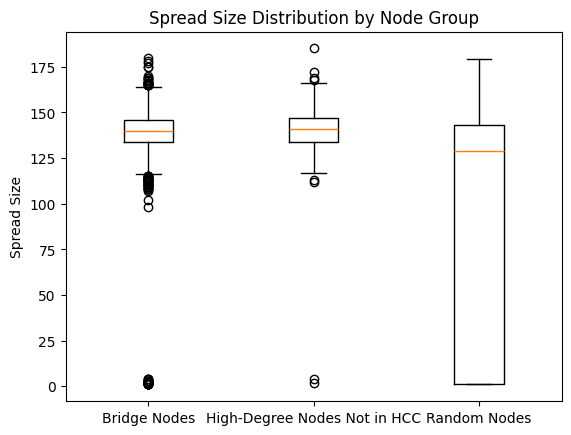

In [22]:
# 17. Visualize the Results

# Boxplot of spread sizes
data = [bridge_spread_sizes, high_degree_spread_sizes, random_spread_sizes]
labels = ['Bridge Nodes', 'High-Degree Nodes Not in HCC', 'Random Nodes']

plt.boxplot(data, labels=labels)
plt.ylabel('Spread Size')
plt.title('Spread Size Distribution by Node Group')
plt.show()